# About this notebook
- tokenizer(anchor[SEP]target | CPC)
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
comp_name = 'us-patent-phrase-to-phrase-matching'
nb_name = 'nb005t-deberta-v3-large'

import sys
print(sys.version)
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    base = f"/content/drive/MyDrive/colab_notebooks/kaggle/{comp_name}/notebooks"
    %cd {base}


import os
INPUT_DIR = f'../input/{comp_name}/'
if 'kaggle_web_client' in sys.modules:
    OUTPUT_DIR = './'
else:
    OUTPUT_DIR = f'../input/{nb_name}/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/kaggle/us-patent-phrase-to-phrase-matching/notebooks


# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    wandb=True
    wandbproject=comp_name
    wandbgroup=nb_name
    wandbname='exp004'
    _wandb_kernel='riow1983'
    apex=True
    print_freq=100
    num_workers=8
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=8
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    #### AWP
    adv_lr=1e-6
    adv_eps=1e-3
    #### AWPAWP
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    CFG.wandb = False

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    if 'google.colab' in sys.modules:
        !pip install wandb
    import wandb

    try:
        if 'kaggle_web_client' in sys.modules:
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
        else:
            import json
            f = open("../../wandb.json", "r")
            json_data = json.load(f)
            secret_value_0 = json_data["wandb_api"]
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))
    
    run = wandb.init(
        dir=OUTPUT_DIR,
        project=CFG.wandbproject,
        group=CFG.wandbgroup,
        name=CFG.wandbname, 
        config=class2dict(CFG),
        job_type="train",
        anonymous=anony)
    print(f"wandb run id: {run.id}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: Currently logged in as: riow1983. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb run id: 26oy5db1


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


# # PyTorchのバージョンを1.10.1に下げる (Google Colabなのでpipでやる)
# os.system('pip uninstall -y torch torchvision torchaudio')
# os.system('pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html')


import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
# os.system('python -m pip install transformers')
# os.system('python -m pip install tokenizers')
os.system('pip install sentencepiece')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
#### TFH
from transformers import AutoModelForTokenClassification
#### TFHTFH
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
# train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
# test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']

train['text'] = train['anchor'] + '[SEP]' + train['target']
test['text'] = test['anchor'] + '[SEP]' + test['target']

train['text2'] = train['context_text']
test['text2'] = test['context_text']


display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text2
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text,text,text2
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural network,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

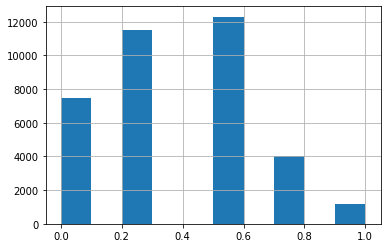

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())



# Credits to https://www.kaggle.com/code/hannes82/pppm-deberta-v3-large-closing-the-cv-lb-gap/notebook#CV-split
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
del dfx
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
# CFG.max_len = max(max(lengths_dict['anchor'])+max(lengths_dict['target'])+3, max(lengths_dict['context_text'])+2)
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text, text2):
    inputs = cfg.tokenizer(text, text2,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.texts2 = df['text2'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item], self.texts2[item])
        #inputs2 = prepare_input(self.cfg, self.texts2[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        #return inputs, inputs2, label
        return inputs, label

In [16]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [17]:
#### TFH
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()

        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out
#### TFHTFH

In [18]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        #### TFH
        # self.attention = nn.Sequential(
        #     nn.Linear(self.config.hidden_size, 512),
        #     nn.Tanh(),
        #     nn.Linear(512, 1),
        #     nn.Softmax(dim=1)
        # )
        self.feature_extractor = AutoModelForTokenClassification.from_pretrained("../input/deberta-v3-large/deberta-v3-large")
        in_features = self.feature_extractor.classifier.in_features
        self.attention = TransformerHead(in_features=in_features, max_length=CFG.max_len, num_layers=1, nhead=8, num_targets=1)
        #### TFHTFH

        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        #### TFH
        # self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        #### TFHTFH
        
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    #### TFH  
    # def feature(self, inputs):
    #     outputs = self.model(**inputs)
    #     last_hidden_states = outputs[0]
        
    #     # outputs2 = self.model(**inputs2)
    #     # last_hidden_states2 = outputs2[0]
        
    #     # feature = torch.mean(last_hidden_states, 1)
    #     weights = self.attention(last_hidden_states)
    #     feature = torch.sum(weights * last_hidden_states, dim=1)
    #     #feature2 = torch.mean(last_hidden_states2, dim=1)
    #     #feature += feature2
    #     return feature
    
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.attention(last_hidden_states)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output
    #### TFHTFH

# Helpler functions

In [19]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

#### AWP
#def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp):
#### AWPAWP
    model.train()
    # AWP
    #scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    # AWPAWP
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0

    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        #### AWP
        if score > 0.75:
            awp.attack_backward(inputs['input_ids'], labels, inputs['attention_mask'], step) 
        #### AWPAWP

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs[1].items():
        #     inputs[1][k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [20]:
#### AWP
class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param="weight",
        adv_lr=1,
        adv_eps=0.2,
        start_epoch=0,
        adv_step=1,
        scaler=None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_epoch = start_epoch
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler

    def attack_backward(self, x, y, attention_mask,epoch):
        if (self.adv_lr == 0) or (epoch < self.start_epoch):
            return None

        self._save() 
        for i in range(self.adv_step):
            self._attack_step() 
            with torch.cuda.amp.autocast():
                adv_loss, tr_logits = self.model(input_ids=x, attention_mask=attention_mask, labels=y)
                adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                # param.data.clamp_(*self.backup_eps[name])

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}

#### AWPAWP

In [21]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    #### AWP
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    awp = AWP(model,
              optimizer,
              adv_lr=CFG.adv_lr,
              adv_eps=CFG.adv_eps,
              start_epoch=num_train_steps/CFG.epochs,
              scaler=scaler)
    score = 0.
    #### AWPAWP
    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        #### AWP
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp)
        #### AWPAWP

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()




    # Push to LINE
    import requests

    def send_line_notification(message):
        import json
        f = open("../../line.json", "r")
        json_data = json.load(f)
        line_token = json_data["kagglePush"]
        endpoint = 'https://notify-api.line.me/api/notify'
        message = "\n{}".format(message)
        payload = {'message': message}
        headers = {'Authorization': 'Bearer {}'.format(line_token)}
        requests.post(endpoint, data=payload, headers=headers)

    if CFG.wandb:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done. See {run.url}")
    else:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done.")

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/3386] Elapsed 0m 0s (remain 56m 16s) Loss: 0.7154(0.7154) Grad: 194568.1406  LR: 0.00002000  
Epoch: [1][100/3386] Elapsed 0m 26s (remain 14m 22s) Loss: 0.5646(0.6579) Grad: 245190.9375  LR: 0.00002000  
Epoch: [1][200/3386] Elapsed 0m 52s (remain 13m 46s) Loss: 0.5020(0.6477) Grad: 63011.7461  LR: 0.00001999  
Epoch: [1][300/3386] Elapsed 1m 17s (remain 13m 15s) Loss: 0.6638(0.6300) Grad: 106463.8281  LR: 0.00001998  
Epoch: [1][400/3386] Elapsed 1m 43s (remain 12m 47s) Loss: 0.5170(0.6207) Grad: 52740.0156  LR: 0.00001996  
Epoch: [1][500/3386] Elapsed 2m 8s (remain 12m 21s) Loss: 0.6341(0.6145) Grad: 45606.6836  LR: 0.00001993  
Epoch: [1][600/3386] Elapsed 2m 34s (remain 11m 58s) Loss: 0.6397(0.6095) Grad: 50343.1953  LR: 0.00001990  
Epoch: [1][700/3386] Elapsed 3m 0s (remain 11m 32s) Loss: 0.5832(0.6060) Grad: 32401.4844  LR: 0.00001987  
Epoch: [1][800/3386] Elapsed 3m 26s (remain 11m 5s) Loss: 0.5601(0.6019) Grad: 57034.3789  LR: 0.00001983  
Epoch: [1][900/3386] E

Epoch 1 - avg_train_loss: 0.5689  avg_val_loss: 0.5518  time: 975s
Epoch 1 - Score: 0.8139
Epoch 1 - Save Best Score: 0.8139 Model


EVAL: [1172/1173] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6854(0.5518) 
Epoch: [2][0/3386] Elapsed 0m 0s (remain 48m 18s) Loss: 0.5559(0.5559) Grad: 21995.3105  LR: 0.00001707  
Epoch: [2][100/3386] Elapsed 0m 26s (remain 14m 37s) Loss: 0.5426(0.5285) Grad: 38935.2617  LR: 0.00001690  
Epoch: [2][200/3386] Elapsed 0m 53s (remain 14m 12s) Loss: 0.5275(0.5287) Grad: 6343.1001  LR: 0.00001674  
Epoch: [2][300/3386] Elapsed 1m 20s (remain 13m 41s) Loss: 0.5876(0.5293) Grad: 100643.4844  LR: 0.00001656  
Epoch: [2][400/3386] Elapsed 1m 45s (remain 13m 5s) Loss: 0.3957(0.5266) Grad: 16392.4004  LR: 0.00001639  
Epoch: [2][500/3386] Elapsed 2m 10s (remain 12m 33s) Loss: 0.4899(0.5265) Grad: 20441.7051  LR: 0.00001621  
Epoch: [2][600/3386] Elapsed 2m 36s (remain 12m 4s) Loss: 0.5427(0.5290) Grad: 13150.2559  LR: 0.00001602  
Epoch: [2][700/3386] Elapsed 3m 1s (remain 11m 35s) Loss: 0.4502(0.5269) Grad: 31434.4590  LR: 0.00001583  
Epoch: [2][800/3386] Elapsed 3m 27s (remain 11m 8s) Loss: 0.5759

Epoch 2 - avg_train_loss: 0.5290  avg_val_loss: 0.5605  time: 972s
Epoch 2 - Score: 0.8241
Epoch 2 - Save Best Score: 0.8241 Model


EVAL: [1172/1173] Elapsed 1m 47s (remain 0m 0s) Loss: 0.6764(0.5605) 
Epoch: [3][0/3386] Elapsed 0m 0s (remain 49m 47s) Loss: 0.6549(0.6549) Grad: 20563.6816  LR: 0.00001000  
Epoch: [3][100/3386] Elapsed 0m 27s (remain 14m 54s) Loss: 0.5139(0.5160) Grad: 22079.3965  LR: 0.00000977  
Epoch: [3][200/3386] Elapsed 0m 54s (remain 14m 19s) Loss: 0.5555(0.5162) Grad: 12513.6709  LR: 0.00000954  
Epoch: [3][300/3386] Elapsed 1m 20s (remain 13m 43s) Loss: 0.5261(0.5130) Grad: 24430.4043  LR: 0.00000931  
Epoch: [3][400/3386] Elapsed 1m 46s (remain 13m 11s) Loss: 0.6376(0.5124) Grad: 19373.2461  LR: 0.00000907  
Epoch: [3][500/3386] Elapsed 2m 12s (remain 12m 40s) Loss: 0.6751(0.5153) Grad: 19383.2305  LR: 0.00000884  
Epoch: [3][600/3386] Elapsed 2m 37s (remain 12m 10s) Loss: 0.5449(0.5136) Grad: 23076.8047  LR: 0.00000861  
Epoch: [3][700/3386] Elapsed 3m 3s (remain 11m 42s) Loss: 0.5422(0.5139) Grad: 49945.4180  LR: 0.00000838  
Epoch: [3][800/3386] Elapsed 3m 29s (remain 11m 15s) Loss: 0.6

Epoch 3 - avg_train_loss: 0.5077  avg_val_loss: 0.5667  time: 969s
Epoch 3 - Score: 0.8269
Epoch 3 - Save Best Score: 0.8269 Model


EVAL: [1172/1173] Elapsed 1m 46s (remain 0m 0s) Loss: 0.6763(0.5667) 
Epoch: [4][0/3386] Elapsed 0m 0s (remain 48m 27s) Loss: 0.3823(0.3823) Grad: 8326.8779  LR: 0.00000293  
Epoch: [4][100/3386] Elapsed 0m 26s (remain 14m 26s) Loss: 0.5600(0.4894) Grad: 2204.6509  LR: 0.00000277  
Epoch: [4][200/3386] Elapsed 0m 52s (remain 13m 59s) Loss: 0.4743(0.4845) Grad: 5966.4951  LR: 0.00000261  
Epoch: [4][300/3386] Elapsed 1m 19s (remain 13m 32s) Loss: 0.4954(0.4881) Grad: 57353.8867  LR: 0.00000246  
Epoch: [4][400/3386] Elapsed 1m 44s (remain 12m 58s) Loss: 0.4059(0.4893) Grad: 56136.8906  LR: 0.00000231  
Epoch: [4][500/3386] Elapsed 2m 9s (remain 12m 27s) Loss: 0.5449(0.4917) Grad: 8970.4424  LR: 0.00000216  
Epoch: [4][600/3386] Elapsed 2m 35s (remain 11m 58s) Loss: 0.6143(0.4939) Grad: 82176.8750  LR: 0.00000202  
Epoch: [4][700/3386] Elapsed 3m 0s (remain 11m 30s) Loss: 0.6917(0.4944) Grad: 130914.3516  LR: 0.00000188  
Epoch: [4][800/3386] Elapsed 3m 25s (remain 11m 3s) Loss: 0.5876(0

Epoch 4 - avg_train_loss: 0.4971  avg_val_loss: 0.5720  time: 965s
Epoch 4 - Score: 0.8264


EVAL: [1172/1173] Elapsed 1m 46s (remain 0m 0s) Loss: 0.6770(0.5720) 


========== fold: 0 result ==========
Score: 0.8269
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/3451] Elapsed 0m 0s (remain 55m 38s) Loss: 0.6949(0.6949) Grad: 84479.7344  LR: 0.00002000  
Epoch: [1][100/3451] Elapsed 0m 26s (remain 14m 28s) Loss: 0.6485(0.6629) Grad: 113836.0078  LR: 0.00002000  
Epoch: [1][200/3451] Elapsed 0m 51s (remain 13m 52s) Loss: 0.6955(0.6586) Grad: 201591.4375  LR: 0.00001999  
Epoch: [1][300/3451] Elapsed 1m 16s (remain 13m 21s) Loss: 0.6003(0.6489) Grad: 59379.1211  LR: 0.00001998  
Epoch: [1][400/3451] Elapsed 1m 41s (remain 12m 53s) Loss: 0.5648(0.6382) Grad: 39161.4453  LR: 0.00001996  
Epoch: [1][500/3451] Elapsed 2m 6s (remain 12m 25s) Loss: 0.5260(0.6313) Grad: 28963.8359  LR: 0.00001994  
Epoch: [1][600/3451] Elapsed 2m 31s (remain 11m 59s) Loss: 0.6705(0.6253) Grad: 36959.4336  LR: 0.00001991  
Epoch: [1][700/3451] Elapsed 2m 57s (remain 11m 35s) Loss: 0.5432(0.6199) Grad: 42294.8945  LR: 0.00001987  
Epoch: [1][800/3451] Elapsed 3m 22s (remain 11m 10s) Loss: 0.5775(0.6127) Grad: 77275.6406  LR: 0.00001983  
Epoch: [1][900/3451] 

Epoch 1 - avg_train_loss: 0.5697  avg_val_loss: 0.5584  time: 976s
Epoch 1 - Score: 0.7949
Epoch 1 - Save Best Score: 0.7949 Model


EVAL: [1107/1108] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6723(0.5584) 
Epoch: [2][0/3451] Elapsed 0m 0s (remain 53m 49s) Loss: 0.5327(0.5327) Grad: 7888.2588  LR: 0.00001707  
Epoch: [2][100/3451] Elapsed 0m 27s (remain 15m 23s) Loss: 0.4224(0.5496) Grad: 12574.6650  LR: 0.00001691  
Epoch: [2][200/3451] Elapsed 0m 54s (remain 14m 47s) Loss: 0.5230(0.5363) Grad: 13826.1670  LR: 0.00001674  
Epoch: [2][300/3451] Elapsed 1m 20s (remain 14m 4s) Loss: 0.3247(0.5323) Grad: 4502.3491  LR: 0.00001657  
Epoch: [2][400/3451] Elapsed 1m 46s (remain 13m 28s) Loss: 0.4979(0.5334) Grad: 5336.2603  LR: 0.00001640  
Epoch: [2][500/3451] Elapsed 2m 12s (remain 12m 57s) Loss: 0.6789(0.5359) Grad: 40968.8398  LR: 0.00001622  
Epoch: [2][600/3451] Elapsed 2m 37s (remain 12m 28s) Loss: 0.4048(0.5339) Grad: 5929.8223  LR: 0.00001604  
Epoch: [2][700/3451] Elapsed 3m 3s (remain 11m 58s) Loss: 0.5808(0.5330) Grad: 19986.6719  LR: 0.00001586  
Epoch: [2][800/3451] Elapsed 3m 28s (remain 11m 28s) Loss: 0.6278(0

Epoch 2 - avg_train_loss: 0.5309  avg_val_loss: 0.5618  time: 976s
Epoch 2 - Score: 0.8156
Epoch 2 - Save Best Score: 0.8156 Model


EVAL: [1107/1108] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6679(0.5618) 
Epoch: [3][0/3451] Elapsed 0m 0s (remain 53m 58s) Loss: 0.5402(0.5402) Grad: 37384.1641  LR: 0.00001000  
Epoch: [3][100/3451] Elapsed 0m 27s (remain 15m 14s) Loss: 0.5060(0.5205) Grad: 18559.7285  LR: 0.00000977  
Epoch: [3][200/3451] Elapsed 0m 54s (remain 14m 43s) Loss: 0.3155(0.5213) Grad: 3001.5710  LR: 0.00000955  
Epoch: [3][300/3451] Elapsed 1m 20s (remain 14m 3s) Loss: 0.4710(0.5146) Grad: 7944.2114  LR: 0.00000932  
Epoch: [3][400/3451] Elapsed 1m 45s (remain 13m 25s) Loss: 0.4587(0.5113) Grad: 9959.9297  LR: 0.00000909  
Epoch: [3][500/3451] Elapsed 2m 11s (remain 12m 54s) Loss: 0.4610(0.5109) Grad: 38707.5508  LR: 0.00000886  
Epoch: [3][600/3451] Elapsed 2m 36s (remain 12m 23s) Loss: 0.5643(0.5096) Grad: 54015.2422  LR: 0.00000864  
Epoch: [3][700/3451] Elapsed 3m 2s (remain 11m 54s) Loss: 0.5397(0.5082) Grad: 6741.9316  LR: 0.00000841  
Epoch: [3][800/3451] Elapsed 3m 27s (remain 11m 26s) Loss: 0.5676(0

Epoch 3 - avg_train_loss: 0.5066  avg_val_loss: 0.5639  time: 979s
Epoch 3 - Score: 0.8198
Epoch 3 - Save Best Score: 0.8198 Model


EVAL: [1107/1108] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6683(0.5639) 
Epoch: [4][0/3451] Elapsed 0m 0s (remain 53m 11s) Loss: 0.5794(0.5794) Grad: 5844.8281  LR: 0.00000293  
Epoch: [4][100/3451] Elapsed 0m 27s (remain 15m 4s) Loss: 0.5440(0.5019) Grad: 4744.1426  LR: 0.00000277  
Epoch: [4][200/3451] Elapsed 0m 53s (remain 14m 25s) Loss: 0.4580(0.5014) Grad: 3420.3059  LR: 0.00000262  
Epoch: [4][300/3451] Elapsed 1m 19s (remain 13m 51s) Loss: 0.4901(0.4983) Grad: 36499.3633  LR: 0.00000246  
Epoch: [4][400/3451] Elapsed 1m 44s (remain 13m 15s) Loss: 0.5648(0.4983) Grad: 8480.3838  LR: 0.00000232  
Epoch: [4][500/3451] Elapsed 2m 9s (remain 12m 44s) Loss: 0.3848(0.4997) Grad: 10890.5225  LR: 0.00000217  
Epoch: [4][600/3451] Elapsed 2m 35s (remain 12m 16s) Loss: 0.4791(0.4988) Grad: 15926.1719  LR: 0.00000203  
Epoch: [4][700/3451] Elapsed 3m 0s (remain 11m 47s) Loss: 0.6764(0.4983) Grad: 19369.4316  LR: 0.00000190  
Epoch: [4][800/3451] Elapsed 3m 25s (remain 11m 19s) Loss: 0.5262(0.

Epoch 4 - avg_train_loss: 0.4970  avg_val_loss: 0.5791  time: 979s
Epoch 4 - Score: 0.8159


EVAL: [1107/1108] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6670(0.5791) 


========== fold: 1 result ==========
Score: 0.8198
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/3482] Elapsed 0m 0s (remain 54m 23s) Loss: 0.7071(0.7071) Grad: 62826.7227  LR: 0.00002000  
Epoch: [1][100/3482] Elapsed 0m 26s (remain 14m 38s) Loss: 0.5722(0.6675) Grad: 103178.0234  LR: 0.00002000  
Epoch: [1][200/3482] Elapsed 0m 51s (remain 14m 4s) Loss: 0.6714(0.6508) Grad: 70930.9297  LR: 0.00001999  
Epoch: [1][300/3482] Elapsed 1m 16s (remain 13m 33s) Loss: 0.5981(0.6386) Grad: 82965.3672  LR: 0.00001998  
Epoch: [1][400/3482] Elapsed 1m 42s (remain 13m 5s) Loss: 0.5873(0.6294) Grad: 114442.3984  LR: 0.00001996  
Epoch: [1][500/3482] Elapsed 2m 7s (remain 12m 39s) Loss: 0.5712(0.6230) Grad: 80167.3047  LR: 0.00001994  
Epoch: [1][600/3482] Elapsed 2m 33s (remain 12m 13s) Loss: 0.6168(0.6169) Grad: 40334.3516  LR: 0.00001991  
Epoch: [1][700/3482] Elapsed 2m 58s (remain 11m 47s) Loss: 0.5951(0.6133) Grad: 48683.7188  LR: 0.00001988  
Epoch: [1][800/3482] Elapsed 3m 23s (remain 11m 21s) Loss: 0.6747(0.6078) Grad: 572489.6875  LR: 0.00001984  
Epoch: [1][900/3482] E

Epoch 1 - avg_train_loss: 0.5864  avg_val_loss: 0.5441  time: 982s
Epoch 1 - Score: 0.8141
Epoch 1 - Save Best Score: 0.8141 Model


EVAL: [1076/1077] Elapsed 1m 38s (remain 0m 0s) Loss: 0.4310(0.5441) 
Epoch: [2][0/3482] Elapsed 0m 0s (remain 50m 9s) Loss: 0.5119(0.5119) Grad: 33850.9844  LR: 0.00001707  
Epoch: [2][100/3482] Elapsed 0m 27s (remain 15m 18s) Loss: 0.3680(0.5318) Grad: 24128.1992  LR: 0.00001691  
Epoch: [2][200/3482] Elapsed 0m 53s (remain 14m 35s) Loss: 0.5675(0.5368) Grad: 15790.8711  LR: 0.00001674  
Epoch: [2][300/3482] Elapsed 1m 19s (remain 14m 4s) Loss: 0.5236(0.5384) Grad: 29887.0488  LR: 0.00001658  
Epoch: [2][400/3482] Elapsed 1m 45s (remain 13m 30s) Loss: 0.3684(0.5358) Grad: 15636.7031  LR: 0.00001640  
Epoch: [2][500/3482] Elapsed 2m 11s (remain 12m 59s) Loss: 0.4551(0.5355) Grad: 20913.6406  LR: 0.00001623  
Epoch: [2][600/3482] Elapsed 2m 36s (remain 12m 30s) Loss: 0.5651(0.5372) Grad: 14150.7412  LR: 0.00001605  
Epoch: [2][700/3482] Elapsed 3m 2s (remain 12m 2s) Loss: 0.5685(0.5374) Grad: 44825.4492  LR: 0.00001587  
Epoch: [2][800/3482] Elapsed 3m 27s (remain 11m 34s) Loss: 0.4143

Epoch 2 - avg_train_loss: 0.5414  avg_val_loss: 0.5715  time: 994s
Epoch 2 - Score: 0.7764


EVAL: [1076/1077] Elapsed 1m 38s (remain 0m 0s) Loss: 0.3740(0.5715) 
Epoch: [3][0/3482] Elapsed 0m 0s (remain 48m 34s) Loss: 0.7672(0.7672) Grad: 107530.7812  LR: 0.00001000  
Epoch: [3][100/3482] Elapsed 0m 26s (remain 14m 42s) Loss: 0.6201(0.5322) Grad: 2914.1418  LR: 0.00000977  
Epoch: [3][200/3482] Elapsed 0m 51s (remain 14m 4s) Loss: 0.5818(0.5289) Grad: 4664.9512  LR: 0.00000955  
Epoch: [3][300/3482] Elapsed 1m 17s (remain 13m 37s) Loss: 0.5345(0.5322) Grad: 3855.7310  LR: 0.00000932  
Epoch: [3][400/3482] Elapsed 1m 43s (remain 13m 13s) Loss: 0.5631(0.5285) Grad: 5631.7041  LR: 0.00000910  
Epoch: [3][500/3482] Elapsed 2m 8s (remain 12m 46s) Loss: 0.2443(0.5262) Grad: 2287.0291  LR: 0.00000887  
Epoch: [3][600/3482] Elapsed 2m 34s (remain 12m 21s) Loss: 0.6611(0.5250) Grad: 25970.8613  LR: 0.00000865  
Epoch: [3][700/3482] Elapsed 3m 0s (remain 11m 55s) Loss: 0.5681(0.5228) Grad: 1428.8335  LR: 0.00000843  
Epoch: [3][800/3482] Elapsed 3m 26s (remain 11m 30s) Loss: 0.4513(0.5

Epoch 3 - avg_train_loss: 0.5192  avg_val_loss: 0.5498  time: 994s
Epoch 3 - Score: 0.8292
Epoch 3 - Save Best Score: 0.8292 Model


EVAL: [1076/1077] Elapsed 1m 38s (remain 0m 0s) Loss: 0.3432(0.5498) 
Epoch: [4][0/3482] Elapsed 0m 0s (remain 50m 41s) Loss: 0.5437(0.5437) Grad: 2075.0483  LR: 0.00000293  
Epoch: [4][100/3482] Elapsed 0m 27s (remain 15m 12s) Loss: 0.5797(0.4864) Grad: 2925.5408  LR: 0.00000277  
Epoch: [4][200/3482] Elapsed 0m 54s (remain 14m 46s) Loss: 0.3861(0.4945) Grad: 678.4516  LR: 0.00000262  
Epoch: [4][300/3482] Elapsed 1m 21s (remain 14m 16s) Loss: 0.4060(0.5006) Grad: 1933.0299  LR: 0.00000247  
Epoch: [4][400/3482] Elapsed 1m 46s (remain 13m 42s) Loss: 0.4739(0.4955) Grad: 4062.9375  LR: 0.00000232  
Epoch: [4][500/3482] Elapsed 2m 12s (remain 13m 8s) Loss: 0.5407(0.4963) Grad: 2906.7341  LR: 0.00000218  
Epoch: [4][600/3482] Elapsed 2m 38s (remain 12m 38s) Loss: 0.5464(0.4972) Grad: 1491.4507  LR: 0.00000204  
Epoch: [4][700/3482] Elapsed 3m 3s (remain 12m 9s) Loss: 0.4564(0.4982) Grad: 81020.8203  LR: 0.00000191  
Epoch: [4][800/3482] Elapsed 3m 29s (remain 11m 41s) Loss: 0.1558(0.4982

Epoch 4 - avg_train_loss: 0.5016  avg_val_loss: 0.5618  time: 995s
Epoch 4 - Score: 0.8308
Epoch 4 - Save Best Score: 0.8308 Model


EVAL: [1076/1077] Elapsed 1m 38s (remain 0m 0s) Loss: 0.3408(0.5618) 


========== fold: 2 result ==========
Score: 0.8308
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/3356] Elapsed 0m 0s (remain 53m 2s) Loss: 0.7251(0.7251) Grad: 171513.5938  LR: 0.00002000  
Epoch: [1][100/3356] Elapsed 0m 27s (remain 14m 48s) Loss: 0.6466(0.6595) Grad: 74536.5000  LR: 0.00002000  
Epoch: [1][200/3356] Elapsed 0m 54s (remain 14m 11s) Loss: 0.6205(0.6486) Grad: 51472.2656  LR: 0.00001999  
Epoch: [1][300/3356] Elapsed 1m 20s (remain 13m 37s) Loss: 0.4963(0.6385) Grad: 56297.9336  LR: 0.00001998  
Epoch: [1][400/3356] Elapsed 1m 46s (remain 13m 2s) Loss: 0.5343(0.6301) Grad: 32639.0332  LR: 0.00001996  
Epoch: [1][500/3356] Elapsed 2m 11s (remain 12m 30s) Loss: 0.6835(0.6219) Grad: 64261.6328  LR: 0.00001993  
Epoch: [1][600/3356] Elapsed 2m 37s (remain 12m 2s) Loss: 0.6082(0.6162) Grad: 58460.2031  LR: 0.00001990  
Epoch: [1][700/3356] Elapsed 3m 3s (remain 11m 33s) Loss: 0.5243(0.6103) Grad: 48725.3867  LR: 0.00001987  
Epoch: [1][800/3356] Elapsed 3m 28s (remain 11m 4s) Loss: 0.6925(0.6059) Grad: 38313.2734  LR: 0.00001982  
Epoch: [1][900/3356] Elaps

Epoch 1 - avg_train_loss: 0.5690  avg_val_loss: 0.5653  time: 975s
Epoch 1 - Score: 0.7733
Epoch 1 - Save Best Score: 0.7733 Model


Epoch: [2][0/3356] Elapsed 0m 0s (remain 48m 30s) Loss: 0.5730(0.5730) Grad: 14198.5801  LR: 0.00001707  
Epoch: [2][100/3356] Elapsed 0m 27s (remain 14m 54s) Loss: 0.6044(0.5361) Grad: 35648.1602  LR: 0.00001690  
Epoch: [2][200/3356] Elapsed 0m 55s (remain 14m 28s) Loss: 0.5068(0.5377) Grad: 9146.3584  LR: 0.00001673  
Epoch: [2][300/3356] Elapsed 1m 22s (remain 13m 52s) Loss: 0.5209(0.5387) Grad: 7388.4468  LR: 0.00001656  
Epoch: [2][400/3356] Elapsed 1m 48s (remain 13m 16s) Loss: 0.5292(0.5374) Grad: 13261.2930  LR: 0.00001638  
Epoch: [2][500/3356] Elapsed 2m 14s (remain 12m 45s) Loss: 0.3451(0.5335) Grad: 6470.2271  LR: 0.00001620  
Epoch: [2][600/3356] Elapsed 2m 40s (remain 12m 15s) Loss: 0.5813(0.5365) Grad: 7166.7944  LR: 0.00001601  
Epoch: [2][700/3356] Elapsed 3m 6s (remain 11m 46s) Loss: 0.6318(0.5345) Grad: 13962.9512  LR: 0.00001582  
Epoch: [2][800/3356] Elapsed 3m 32s (remain 11m 18s) Loss: 0.5302(0.5360) Grad: 3689.9785  LR: 0.00001563  
Epoch: [2][900/3356] Elapsed

Epoch 2 - avg_train_loss: 0.5293  avg_val_loss: 0.5745  time: 985s
Epoch 2 - Score: 0.7972
Epoch 2 - Save Best Score: 0.7972 Model


Epoch: [3][0/3356] Elapsed 0m 0s (remain 53m 19s) Loss: 0.6066(0.6066) Grad: 10023.5254  LR: 0.00001000  
Epoch: [3][100/3356] Elapsed 0m 27s (remain 14m 48s) Loss: 0.4860(0.4967) Grad: 10248.4229  LR: 0.00000976  
Epoch: [3][200/3356] Elapsed 0m 54s (remain 14m 14s) Loss: 0.5303(0.4987) Grad: 5624.6206  LR: 0.00000953  
Epoch: [3][300/3356] Elapsed 1m 20s (remain 13m 39s) Loss: 0.4674(0.5127) Grad: 12298.7861  LR: 0.00000930  
Epoch: [3][400/3356] Elapsed 1m 46s (remain 13m 3s) Loss: 0.2536(0.5134) Grad: 9088.9863  LR: 0.00000906  
Epoch: [3][500/3356] Elapsed 2m 11s (remain 12m 31s) Loss: 0.5455(0.5119) Grad: 5723.8672  LR: 0.00000883  
Epoch: [3][600/3356] Elapsed 2m 37s (remain 12m 3s) Loss: 0.3932(0.5108) Grad: 4316.3999  LR: 0.00000860  
Epoch: [3][700/3356] Elapsed 3m 3s (remain 11m 35s) Loss: 0.5171(0.5122) Grad: 5410.2715  LR: 0.00000837  
Epoch: [3][800/3356] Elapsed 3m 29s (remain 11m 9s) Loss: 0.4775(0.5126) Grad: 5590.0171  LR: 0.00000814  
Epoch: [3][900/3356] Elapsed 3m 

Epoch 3 - avg_train_loss: 0.5100  avg_val_loss: 0.5740  time: 979s
Epoch 3 - Score: 0.8002
Epoch 3 - Save Best Score: 0.8002 Model


Epoch: [4][0/3356] Elapsed 0m 0s (remain 51m 12s) Loss: 0.6036(0.6036) Grad: 4270.8921  LR: 0.00000293  
Epoch: [4][100/3356] Elapsed 0m 27s (remain 14m 53s) Loss: 0.4582(0.4865) Grad: 3906.2839  LR: 0.00000277  
Epoch: [4][200/3356] Elapsed 0m 54s (remain 14m 18s) Loss: 0.3063(0.4923) Grad: 8066.2764  LR: 0.00000261  
Epoch: [4][300/3356] Elapsed 1m 21s (remain 13m 43s) Loss: 0.4389(0.4907) Grad: 868.1865  LR: 0.00000245  
Epoch: [4][400/3356] Elapsed 1m 46s (remain 13m 5s) Loss: 0.6981(0.4936) Grad: 191786.7656  LR: 0.00000230  
Epoch: [4][500/3356] Elapsed 2m 12s (remain 12m 32s) Loss: 0.4192(0.4903) Grad: 4240.1494  LR: 0.00000215  
Epoch: [4][600/3356] Elapsed 2m 37s (remain 12m 2s) Loss: 0.4557(0.4917) Grad: 4032.6394  LR: 0.00000201  
Epoch: [4][700/3356] Elapsed 3m 3s (remain 11m 33s) Loss: 0.6070(0.4942) Grad: 1082.1162  LR: 0.00000187  
Epoch: [4][800/3356] Elapsed 3m 28s (remain 11m 5s) Loss: 0.5756(0.4947) Grad: 7675.8296  LR: 0.00000174  
Epoch: [4][900/3356] Elapsed 3m 54

Epoch 4 - avg_train_loss: 0.4981  avg_val_loss: 0.5833  time: 974s
Epoch 4 - Score: 0.7975
========== fold: 3 result ==========
Score: 0.8002
========== CV ==========
Score: 0.8192


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▁▄▆█
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▆█▄█▅▅▄▃▂▆▃▆▅▅▆▆▅▆█▅▅▅▄▅█▄▅▁▆▂▅▆▄▅▃▄▅▅
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆██
[fold1] avg_train_loss,█▄▂▁
[fold1] avg_val_loss,▁▂▃█
[fold1] epoch,▁▃▆█
[fold1] loss,▇▆▇▄▇▇▄▄▄▅▆▆▇▅▇▆▁▄▂▂▅▃▃▅▆▄▆▅▄▃▁▃▄▆▄▄▅█▅▂
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
